In [3]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [4]:
data1 = pd.read_csv('dim_customers.csv')
data1.info() # no nulls, 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     4000 non-null   object
 1   age_group       4000 non-null   object
 2   city            4000 non-null   object
 3   occupation      4000 non-null   object
 4   gender          4000 non-null   object
 5   marital status  4000 non-null   object
 6   avg_income      4000 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 218.9+ KB


In [ ]:
# UNIVARIATE ANALYSIS  # 4000 unique customers
# 2 genders(1403 F, 2597M)~(1400F,2600M), married status (married-3136, single-864)
# 4 age groups(21-24 691; 25-34 1498; 35-45 1273; 45+ 538) , 5 cities (Mumbai 1078; Chennai 834; Bengaluru 751; Delhi NCR 744; Hyderabad 593)
# occcupation (Salaried IT Employees 1294; Salaried Other Employees 893; Freelancers 784; Business Owners 630; Government Employees 399)

In [26]:
pd.crosstab(data1['age_group'],data1['gender'],margins=True)         # f:m 21-24 (~3:5), 25-34 (~11:20), 35-45 (~1:2), 45+ (~1:2)
pd.crosstab(data1['age_group'],data1['marital status'],margins=True) # most singles between 21-24 (5/7), 25-34(1/5), 35-45 (1/17), 45+ (1/49)
pd.crosstab(data1['marital status'],data1['gender'],margins=True)    # 1136F married & 2000M; 267F single while 600M single

gender,Female,Male,All
marital status,,,
Married,1136,2000,3136
Single,267,597,864
All,1403,2597,4000


In [27]:
data1['occupation'].value_counts()

occupation
Salaried IT Employees       1294
Salaried Other Employees     893
Freelancers                  784
Business Owners              630
Government Employees         399
Name: count, dtype: int64

In [28]:
data1[['occupation','city']].value_counts().sort_values()

occupation                city     
Government Employees      Hyderabad     64
                          Delhi NCR     67
                          Bengaluru     76
                          Chennai       92
                          Mumbai       100
Business Owners           Hyderabad    102
                          Delhi NCR    113
                          Chennai      115
                          Bengaluru    115
Freelancers               Hyderabad    118
Salaried Other Employees  Hyderabad    121
Freelancers               Delhi NCR    136
Salaried Other Employees  Bengaluru    143
Freelancers               Chennai      151
Salaried Other Employees  Delhi NCR    169
Business Owners           Mumbai       185
Salaried IT Employees     Hyderabad    188
Freelancers               Mumbai       188
                          Bengaluru    191
Salaried Other Employees  Chennai      219
Salaried IT Employees     Bengaluru    226
Salaried Other Employees  Mumbai       241
Salaried IT Employ

In [29]:
# BI-VARIATE ANALYSIS
data1.groupby(['gender'])['avg_income'].mean().round(-2).sort_values() # avg incomes didnt differ much by gender
data1.groupby(['age_group'])['avg_income'].mean().round(-2).sort_values() #  21-24 41k; 25-34 52k; 35-45 54k; 45+ 61k - incremental (40-60k)
data1.groupby(['city'])['avg_income'].mean().round(-2).sort_values() # 51100-52300; not much difference BCMDH order
data1.groupby(['occupation'])['avg_income'].mean().round(-2).sort_values()
# freelancers 35k; other emps 39k; govt emps 52k; IT emps 61.5k; business owners 70k)
data1.groupby(['marital status'])['avg_income'].mean().round(-2).sort_values() # singles - 46k (can spend more), married - 53k (have responsibilities but needs for credit card)

marital status
Single     45600.0
Married    53300.0
Name: avg_income, dtype: float64

In [30]:
data2 = pd.read_csv('fact_spends.csv')
data2.info() # 864k rows, no nulls, cust_id, month, category, payment_type, spend # 4000 cust * 6 months * 9 categories * 4 payment_types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864000 entries, 0 to 863999
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   customer_id   864000 non-null  object
 1   month         864000 non-null  object
 2   category      864000 non-null  object
 3   payment_type  864000 non-null  object
 4   spend         864000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 33.0+ MB


In [82]:
merged_data = pd.merge(data1,data2,on='customer_id')
merged_data.groupby(['customer_id','month'])['avg_income'].count().head(10) # 9 cats* 4 payment_types*6 months(May to October) each for 4k customers = 864k rows
merged_data

,customer_id,age_group,city,occupation,gender,marital status,avg_income,month,category,payment_type,spend
0,ATQCUS1825,45+,Bengaluru,Salaried IT Employees,Male,Married,73523,May,Electronics,Net Banking,405
1,ATQCUS1825,45+,Bengaluru,Salaried IT Employees,Male,Married,73523,May,Groceries,Debit Card,1096
2,ATQCUS1825,45+,Bengaluru,Salaried IT Employees,Male,Married,73523,June,Bills,Credit Card,2765
3,ATQCUS1825,45+,Bengaluru,Salaried IT Employees,Male,Married,73523,September,Apparel,Debit Card,363
4,ATQCUS1825,45+,Bengaluru,Salaried IT Employees,Male,Married,73523,May,Food,Debit Card,334
...,...,...,...,...,...,...,...,...,...,...,...
863995,ATQCUS3477,25-34,Mumbai,Business Owners,Male,Single,73541,May,Bills,Net Banking,548
863996,ATQCUS3477,25-34,Mumbai,Business Owners,Male,Single,73541,October,Apparel,UPI,174
863997,ATQCUS3477,25-34,Mumbai,Business Owners,Male,Single,73541,September,Food,Debit Card,346
863998,ATQCUS3477,25-34,Mumbai,Business Owners,Male,Single,73541,June,Apparel,Net Banking,54


(array([ 59., 273., 533., 840., 689., 593., 520., 309., 116.,  68.]),
 array([14. , 20.3, 26.6, 32.9, 39.2, 45.5, 51.8, 58.1, 64.4, 70.7, 77. ]),
 <BarContainer object of 10 artists>)

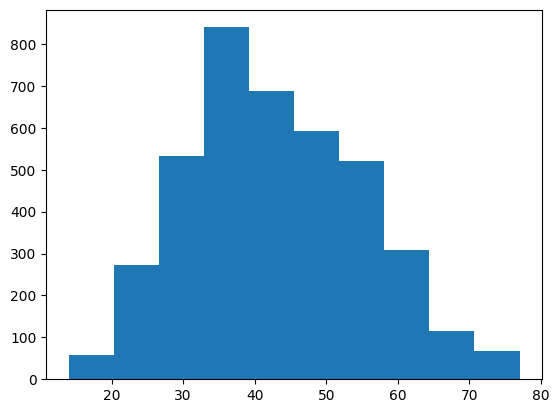

In [102]:
# insight 1 - AVG_INCOME_UTILISATION_RATIO
df1 = merged_data.groupby(['customer_id'])['avg_income'].mean()*6
df2 = merged_data.groupby(['customer_id'])['spend'].sum()
df = pd.concat([df1,df2],axis=1)
df['avg_income_util_percent'] = (100* df['spend']/df['avg_income']).round(0)
df.sort_values(by='avg_income_util_percent',ascending=False)
plt.hist(df['avg_income_util_percent'])
# if my avg_income_util_percent threshold can be either 50% or 60%

In [116]:
set1 = df.loc[df['avg_income_util_percent']>50].reset_index()
cust_set1 = pd.merge(data1[['customer_id','age_group','city','gender','marital status']],set1, on='customer_id')
cust_set1.sort_values(by='avg_income_util_percent',ascending=False)

,customer_id,age_group,city,gender,marital status,avg_income,spend,avg_income_util_percent
855,ATQCUS0912,35-45,Mumbai,Male,Married,381750.0,295379,77.0
403,ATQCUS0918,35-45,Mumbai,Male,Married,413370.0,315201,76.0
864,ATQCUS0166,25-34,Mumbai,Male,Married,352416.0,266182,76.0
692,ATQCUS0943,35-45,Mumbai,Male,Married,393780.0,300422,76.0
920,ATQCUS0163,25-34,Mumbai,Male,Married,351348.0,267974,76.0
...,...,...,...,...,...,...,...,...
147,ATQCUS2159,25-34,Mumbai,Female,Married,205800.0,105906,51.0
74,ATQCUS1539,35-45,Hyderabad,Male,Married,400530.0,204362,51.0
1014,ATQCUS0430,25-34,Delhi NCR,Male,Married,211812.0,107800,51.0
1015,ATQCUS1261,35-45,Bengaluru,Male,Married,249786.0,127911,51.0


In [153]:
# insight2 - spend by category impact by occupation, gender, city, age, place ???
df1 = data2.groupby(['customer_id','category'])['spend'].sum().reset_index()
df2 = data2.groupby('customer_id')['spend'].sum().reset_index()
df3 = df1.merge(df2, on ='customer_id', how='outer',suffixes=('_by_cat','_overall'))
df3['cat_spend_percent'] = (100*df3['spend_by_cat']/df3['spend_overall']).round(0)
df3.sort_values(by='cat_spend_percent',ascending=False).head(50)

,customer_id,category,spend_by_cat,spend_overall,cat_spend_percent
25872,ATQCUS2875,Health & Wellness,20452,64878,32.0
24513,ATQCUS2724,Health & Wellness,60041,201015,30.0
24504,ATQCUS2723,Health & Wellness,57421,193308,30.0
57,ATQCUS0007,Entertainment,46903,158844,30.0
9199,ATQCUS1023,Bills,36550,125345,29.0
23757,ATQCUS2640,Health & Wellness,56789,195758,29.0
8470,ATQCUS0942,Bills,76538,261785,29.0
23847,ATQCUS2650,Health & Wellness,70590,244013,29.0
408,ATQCUS0046,Entertainment,41947,146716,29.0
26601,ATQCUS2956,Health & Wellness,20663,71622,29.0


In [37]:
# new_data.groupby('age_group')[['avg_income','spend','savings']].mean().round(-2) # 45+ has most savings (high income low expense), 21-24 low income low expense
# new_data.groupby('city')[['avg_income','spend','savings']].mean().round(-2) # chennai, hyd affordable places, mumbai expensive. look at spending categories
# new_data.groupby('occupation')[['avg_income','spend','savings']].mean().round(-2)
# new_data.groupby(['age_group','marital status'])[['avg_income','spend','savings']].mean().round(-2).sort_values(by='savings')
# may be new_data = merged_data workss the same

avg_income     spend   savings
age_group marital status                                
21-24     Single            243700.0  100000.0  143700.0
          Married           245800.0   97200.0  148600.0
35-45     Single            314500.0  150400.0  164000.0
          Married           320900.0  149700.0  171200.0
25-34     Single            310700.0  138900.0  171800.0
          Married           311000.0  135000.0  176000.0
45+       Single            371900.0  146100.0  225800.0
          Married           366200.0  126700.0  239500.0

In [38]:
# analyse spend categry and payments
fr = data2.groupby(['customer_id','month','category','payment_type'])['spend'].mean().round(-2).sort_values(ascending=False).reset_index()

In [39]:
# fr.loc[(fr['payment_type']=='Net Banking') & (fr['spend']==0)]
# # 2952 customers of 4000 dont use net banking for some categories and some months; 19625/216000 are zero.
# fr.loc[(fr['payment_type']=='Credit Card')] # 92/216k rows with zero spend. 4000cust*6months*9 cats

,customer_id,month,category,payment_type,spend
841692,ATQCUS2076,June,Groceries,Net Banking,0.0
841693,ATQCUS3595,July,Apparel,Net Banking,0.0
841694,ATQCUS0802,October,Others,Net Banking,0.0
841695,ATQCUS2040,October,Others,Net Banking,0.0
841696,ATQCUS1415,October,Others,Net Banking,0.0
...,...,...,...,...,...
863995,ATQCUS1189,May,Apparel,Net Banking,0.0
863996,ATQCUS3802,May,Bills,Net Banking,0.0
863997,ATQCUS3377,August,Travel,Net Banking,0.0
863998,ATQCUS0016,June,Others,Net Banking,0.0


In [121]:
# df_n = data2.groupby(['customer_id','payment_type'])['spend'].sum().sort_values(ascending=False).head(4000).reset_index()
# df_n.loc[df_n['payment_type']=='Credit Card'] #2366 out of top 4000 payments_by_payment_mode are credit card ~ 59%

In [42]:
#merged_data.groupby(['customer_id','category'])['spend'].sum().sort_values(ascending=False).head(50)
# so, bills (followed by health&wellness) is the category of highest spend

In [123]:
#f1 = merged_data.groupby('customer_id')[['spend']].sum().merge(data1[['customer_id','gender','age_group']], on= 'customer_id')
#f1.groupby(['gender','age_group'])['spend'].mean()

4000

In [1]:
merged_data

NameError: name 'merged_data' is not defined